In [199]:

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import utils as ut

In [200]:
# make def
import numpy as np
def cart2hom( pts_3d):
    """ Input: nx3 points in Cartesian
        Oupput: nx4 points in Homogeneous by pending 1
    """
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
    return pts_3d_hom

def project_velo_to_ref( V2C, pts_3d_velo):
    pts_3d_velo = cart2hom(pts_3d_velo)  # nx4
    return np.dot(pts_3d_velo, np.transpose(V2C))

def project_ref_to_rect(R0, pts_3d_ref):
    """ Input and Output are nx3 points """
    return np.transpose(np.dot(R0, np.transpose(pts_3d_ref)))

def project_velo_to_rect( V2C, pts_3d_velo, R0):
        pts_3d_ref = project_velo_to_ref(V2C, pts_3d_velo)
        return project_ref_to_rect(R0,pts_3d_ref)


In [201]:
# make path
path_image = "sample_data/object/image/front/"
path_lidar = "sample_data/object/roof/"
path_camera = "sample_data/object/front/"
path_calib = "sample_data/object/calib/front/"
path_front_left = "sample_data/object/front_left/"
path_front_right = "sample_data/object/front_right/"
path_roof = "sample_data/object/roof/"
image_path_list = os.listdir(path_image)
lidar_path_list = os.listdir(path_lidar)
camera_path_list = os.listdir(path_camera)
calib_path_list = os.listdir(path_calib)
front_left_path_list = os.listdir(path_front_left)
front_right_path_list = os.listdir(path_front_right)
roof_path_list = os.listdir(path_roof)

In [205]:
import json

for image_name in camera_path_list:
    # Make json data
    with open(f'{path_camera}{image_name}',"r") as f:
        contents_camera = f.read()
        json_data_camera = json.loads(contents_camera)
    
    with open(f'{path_lidar}{image_name}',"r") as f:
        contents_lidar = f.read()
        json_data_lidar = json.loads(contents_lidar)
    
    with open(f'{path_front_left}{image_name}',"r") as f:
        contents_front_left = f.read()
        json_data_front_left = json.loads(contents_front_left)
    
    with open(f'{path_front_right}{image_name}',"r") as f:
        contents_front_right = f.read()
        json_data_front_right = json.loads(contents_front_right)

    with open(f'{path_roof}{image_name}',"r") as f:
        contents_roof = f.read()
        json_data_roof = json.loads(contents_roof)
    
    with open(f'{path_calib}{image_name.split(".")[0]}.txt','r') as f:
        Tr_velo_to_cam = []
        R0 = []
        contents_calib = f.readlines()
        data_calib = contents_calib[2].split(' ')
        data_R0_s = contents_calib[1].split(' ')

        for calib in data_calib[1:]:
            if calib == data_calib[-1]:
                Tr_velo_to_cam.append(float(calib[:-1]))
            else:
                Tr_velo_to_cam.append(float(calib))

        for R0s in data_R0_s[1:]:
            if R0s == data_R0_s[-1]:
                R0.append(float(R0s[:-1]))
            else:
                R0.append(float(R0s))

        R0 = np.reshape(R0, [3, 3])
    
    # make id check list and txt
    f = open(f'sample_data/object/translated/aihub_to_kitti/{image_name.split(".")[0]}.txt','w')
    f.close()
    f2 = open(f'sample_data/object/translated/lidar_to_cam/{image_name.split(".")[0]}.txt','w')
    f2.close()

    cnt_lidar_count = 0

    for camera_annotations in json_data_camera['annotations']:
        check_list_id = []
        # front_left_check
        for lidar_annotations in json_data_front_left['annotations']:
            # if camera_annotations['bbox.id'] == lidar_annotations['3dbbox.id'] and camera_annotations['bbox.id'] not in check_list_id :
            if  camera_annotations['bbox.id'] not in check_list_id :
                check_list_id.append(camera_annotations['bbox.id'])
                cnt_lidar_count += 1

                # read aihub annotation
                category = str.title(str(lidar_annotations['3dbbox.category']))
                truncated = str(lidar_annotations['3dbbox.truncated'])
                occuluded = str(lidar_annotations['3dbbox.occluded'])
                rotatin_y = str(lidar_annotations['3dbbox.rotation_y'])
                x_2d, y_2d, h_2d,w_2d = str(camera_annotations['bbox.x']),str(camera_annotations['bbox.y']),str(camera_annotations['bbox.height']),str(camera_annotations['bbox.width'])
                h_3d, w_3d, l_3d = str(lidar_annotations['3dbbox.dimension'][0]), str(lidar_annotations['3dbbox.dimension'][1]), str(lidar_annotations['3dbbox.dimension'][2])
                x_3d, y_3d, z_3d = str(lidar_annotations['3dbbox.location'][0]), str(lidar_annotations['3dbbox.location'][1]), str(lidar_annotations['3dbbox.location'][2])
                z_3d_to_kitti = str(lidar_annotations['3dbbox.location'][2] - lidar_annotations['3dbbox.dimension'][2]/2)
        

                # translate lidar to camera 
                v_to_c= np.array(Tr_velo_to_cam)
                V2C = np.reshape(v_to_c, [3, 4])
                xyz_3d = np.array([[float(x_3d), float(y_3d), float(z_3d_to_kitti)]])
                project_xyz_3d = project_velo_to_rect(V2C, xyz_3d, R0)
                x_p,y_p,z_p = project_xyz_3d[0][0], project_xyz_3d[0][1], project_xyz_3d[0][2]

                # Save aihub_to_kitti
                with open(f'sample_data/object/translated/aihub_to_kitti/{image_name.split(".")[0]}.txt','a') as f:
                    f.write(category + ' ' + truncated + ' ' + occuluded + ' ' + rotatin_y + ' ' + x_2d + ' ' + y_2d + ' ' + h_2d +  
                    ' ' + w_2d + ' ' + h_3d+ ' ' + w_3d+ ' ' + l_3d + ' ' + x_3d + ' ' + y_3d + ' ' + z_3d_to_kitti + ' ' + rotatin_y + '\n')

                # Save Lidar_to_cam
                with open(f'sample_data/object/translated/lidar_to_cam/{image_name.split(".")[0]}.txt','a') as f:
                    f.write(category + ' ' + truncated + ' ' + occuluded + ' ' + rotatin_y + ' ' + x_2d + ' ' + y_2d + ' ' + h_2d +  
                    ' ' + w_2d + ' ' + h_3d+ ' ' + w_3d+ ' ' + l_3d + ' ' + str(x_p) + ' ' + str(y_p) + ' ' + str(z_p) + ' ' + rotatin_y + '\n')

        # front_right_check
        for lidar_annotations in json_data_front_right['annotations']:
            if camera_annotations['bbox.id'] == lidar_annotations['3dbbox.id'] and camera_annotations['bbox.id'] not in check_list_id :
                check_list_id.append(camera_annotations['bbox.id'])
                cnt_lidar_count += 1

                # read aihub annotation
                category = str.title(str(lidar_annotations['3dbbox.category']))
                truncated = str(lidar_annotations['3dbbox.truncated'])
                occuluded = str(lidar_annotations['3dbbox.occluded'])
                rotatin_y = str(lidar_annotations['3dbbox.rotation_y'])
                x_2d, y_2d, h_2d,w_2d = str(camera_annotations['bbox.x']),str(camera_annotations['bbox.y']),str(camera_annotations['bbox.height']),str(camera_annotations['bbox.width'])
                h_3d, w_3d, l_3d = str(lidar_annotations['3dbbox.dimension'][0]), str(lidar_annotations['3dbbox.dimension'][1]), str(lidar_annotations['3dbbox.dimension'][2])
                x_3d, y_3d, z_3d = str(lidar_annotations['3dbbox.location'][0]), str(lidar_annotations['3dbbox.location'][1]), str(lidar_annotations['3dbbox.location'][2])
                z_3d_to_kitti = str(lidar_annotations['3dbbox.location'][2] - lidar_annotations['3dbbox.dimension'][2]/2)

                # translate lidar to camera 
                v_to_c= np.array(Tr_velo_to_cam)
                V2C = np.reshape(v_to_c, [3, 4])
                xyz_3d = np.array([[float(x_3d), float(y_3d), float(z_3d_to_kitti)]])
                project_xyz_3d = project_velo_to_rect(V2C, xyz_3d, R0)
                x_p,y_p,z_p = project_xyz_3d[0][0], project_xyz_3d[0][1], project_xyz_3d[0][2]

                # Save aihub_to_kitti
                with open(f'sample_data/object/translated/aihub_to_kitti/{image_name.split(".")[0]}.txt','a') as f:
                    f.write(category + ' ' + truncated + ' ' + occuluded + ' ' + rotatin_y + ' ' + x_2d + ' ' + y_2d + ' ' + h_2d +  
                    ' ' + w_2d + ' ' + h_3d+ ' ' + w_3d+ ' ' + l_3d + ' ' + x_3d + ' ' + y_3d + ' ' + z_3d_to_kitti + ' ' + rotatin_y + '\n')

                # Save Lidar_to_cam
                with open(f'sample_data/object/translated/lidar_to_cam/{image_name.split(".")[0]}.txt','a') as f:
                    f.write(category + ' ' + truncated + ' ' + occuluded + ' ' + rotatin_y + ' ' + x_2d + ' ' + y_2d + ' ' + h_2d +  
                    ' ' + w_2d + ' ' + h_3d+ ' ' + w_3d+ ' ' + l_3d + ' ' + str(x_p) + ' ' + str(y_p) + ' ' + str(z_p) + ' ' + rotatin_y + '\n')
                
                # Save cam_to_image

        # roof_check
        for lidar_annotations in json_data_roof['annotations']:
            if camera_annotations['bbox.id'] == lidar_annotations['3dbbox.id'] and camera_annotations['bbox.id'] not in check_list_id :
                check_list_id.append(camera_annotations['bbox.id'])
                cnt_lidar_count += 1

                # read aihub annotation
                category = str.title(str(lidar_annotations['3dbbox.category']))
                truncated = str(lidar_annotations['3dbbox.truncated'])
                occuluded = str(lidar_annotations['3dbbox.occluded'])
                rotatin_y = str(lidar_annotations['3dbbox.rotation_y'])
                x_2d, y_2d, h_2d,w_2d = str(camera_annotations['bbox.x']),str(camera_annotations['bbox.y']),str(camera_annotations['bbox.height']),str(camera_annotations['bbox.width'])
                h_3d, w_3d, l_3d = str(lidar_annotations['3dbbox.dimension'][0]), str(lidar_annotations['3dbbox.dimension'][1]), str(lidar_annotations['3dbbox.dimension'][2])
                x_3d, y_3d, z_3d = str(lidar_annotations['3dbbox.location'][0]), str(lidar_annotations['3dbbox.location'][1]), str(lidar_annotations['3dbbox.location'][2])
                z_3d_to_kitti = str(lidar_annotations['3dbbox.location'][2] - lidar_annotations['3dbbox.dimension'][2]/2)

                # translate lidar to camera 
                v_to_c= np.array(Tr_velo_to_cam)
                V2C = np.reshape(v_to_c, [3, 4])
                xyz_3d = np.array([[float(x_3d), float(y_3d), float(z_3d_to_kitti)]])
                project_xyz_3d = project_velo_to_rect(V2C, xyz_3d, R0)
                x_p,y_p,z_p = project_xyz_3d[0][0], project_xyz_3d[0][1], project_xyz_3d[0][2]

                # Save aihub_to_kitti
                with open(f'sample_data/object/translated/aihub_to_kitti/{image_name.split(".")[0]}.txt','a') as f:
                    f.write(category + ' ' + truncated + ' ' + occuluded + ' ' + rotatin_y + ' ' + x_2d + ' ' + y_2d + ' ' + h_2d +  
                    ' ' + w_2d + ' ' + h_3d+ ' ' + w_3d+ ' ' + l_3d + ' ' + x_3d + ' ' + y_3d + ' ' + z_3d_to_kitti + ' ' + rotatin_y + '\n')

                # Save Lidar_to_cam
                with open(f'sample_data/object/translated/lidar_to_cam/{image_name.split(".")[0]}.txt','a') as f:
                    f.write(category + ' ' + truncated + ' ' + occuluded + ' ' + rotatin_y + ' ' + x_2d + ' ' + y_2d + ' ' + h_2d +  
                    ' ' + w_2d + ' ' + h_3d+ ' ' + w_3d+ ' ' + l_3d + ' ' + str(x_p) + ' ' + str(y_p) + ' ' + str(z_p) + ' ' + rotatin_y+ '\n')
                
                # Save cam_to_image

    # data_cleaning
    check_camera_count = json_data_camera['Images.num_object']
    with open(f'sample_data/object/translated/aihub_to_kitti/{image_name.split(".")[0]}.txt','r') as f:
        contents_label= f.readlines()
    
    contents_label_count = len(contents_label)
    if check_camera_count > contents_label_count + 1 or  contents_label_count == 0:
        os.remove(f'sample_data/object/translated/aihub_to_kitti/{image_name.split(".")[0]}.txt')
        os.remove(f'sample_data/object/translated/lidar_to_cam/{image_name.split(".")[0]}.txt')

KITTIObject
 - Difficulty:Easy
 - Label:Dontcare | Truncation:0.0 | Occlusion:0 | Alpha:3.093369483947754
 - 2DBbox @ Pos:(904.74609375,616.3671875),(52.6328125,67.22743225097656)
 - 3DBbox @ Pos:(-19.301459538961847,8.552345698495513,20.162882245337293) | Yaw:3.093369483947754 | HWL:(23.24385643005371,2.878655433654785,15.783514022827148)
KITTIObject
 - Difficulty:Easy
 - Label:Dontcare | Truncation:0.0 | Occlusion:0 | Alpha:3.093369483947754
 - 2DBbox @ Pos:(993.8000000000011,607.0205078125),(37.579492187500364,46.42608947753797)
 - 3DBbox @ Pos:(-19.301459538961847,8.552345698495513,20.162882245337293) | Yaw:3.093369483947754 | HWL:(23.24385643005371,2.878655433654785,15.783514022827148)
KITTIObject
 - Difficulty:Easy
 - Label:Dontcare | Truncation:0.0 | Occlusion:0 | Alpha:3.093369483947754
 - 2DBbox @ Pos:(1099.498046875,611.3876953125),(81.21230468750036,100.40184020996094)
 - 3DBbox @ Pos:(-19.301459538961847,8.552345698495513,20.162882245337293) | Yaw:3.093369483947754 | HWL:(2

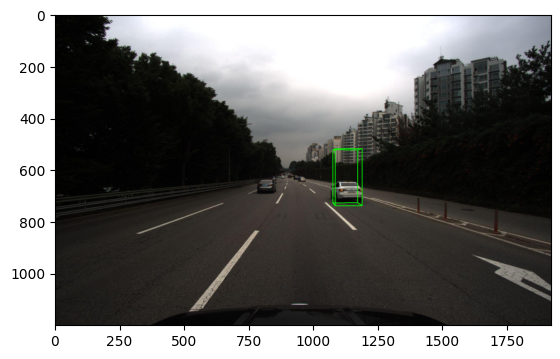

In [206]:
# cam_to_image
def custom_get_label_objects(label_dir, idx):
    label_filename = os.path.join(label_dir, f"{idx}")
    return ut.read_label(label_filename)
def get_calibration(calib_path, idx):
    calib_filename = os.path.join(calib_path, f"{idx}")
    return ut.Calibration(calib_filename)

path_label= './sample_data/object/translated/lidar_to_cam'
label_list = os.listdir(path_label)

for target in label_list:
    CONFIG = {
    "calib_path" : './sample_data/object/calib/front',
    "label_path" : './sample_data/object/translated/lidar_to_cam',
    "image_path" : './sample_data/object/image/front',
    "target_idx" : target,
}

    target_objects = custom_get_label_objects(CONFIG['label_path'], CONFIG['target_idx'])
    calib = get_calibration(CONFIG['calib_path'], CONFIG['target_idx'])
    for obj in target_objects:
        obj.print_object()
    try:
        target_image = cv2.cvtColor(cv2.imread(os.path.join(CONFIG['image_path'], f"{CONFIG['target_idx'][:-4]}.jpg")), cv2.COLOR_BGR2RGB)
    except: 
        print(f"{CONFIG['target_idx'][:-4]}.jpg")
        target_image = cv2.cvtColor(cv2.imread(os.path.join(CONFIG['image_path'], f"{CONFIG['target_idx'][:-4]}.jpg")), cv2.COLOR_BGR2RGB)
    img = ut.show_image_with_boxes(target_image, target_objects, calib)
    cv2.imwrite(f'./sample_data/object/save_img/{target}.png',img)
    plt.imshow(img)

